In [1]:
import torch
from transformers import SamProcessor, SamModel
from transformers import AutoProcessor
from transformers import Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import transformers
import requests
import json
import re
from io import BytesIO
import warnings
from huggingface_hub import snapshot_download
from pathlib import Path
import os, sys
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version: {torch.__version__}, using device: {device}")
print(f"transformers version: {transformers.__version__}")

# !pip install qwen-vl-utils

torch version: 2.6.0+cu124, using device: cuda
transformers version: 4.52.4


In [2]:

if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    HF_MODELS_DIR = Path("/content/drive/MyDrive/hf_models")
else:
    HF_MODELS_DIR = Path(r"G:\Mi unidad\hf_models")

HF_MODELS_DIR.mkdir(parents=True, exist_ok=True)

models = [
    "facebook/sam-vit-large",
    "Qwen/Qwen2.5-VL-3B-Instruct",
]

for repo in models:
    local_dir = HF_MODELS_DIR / repo
    snapshot_download(
        repo_id=repo,
        local_dir=str(local_dir),
        local_dir_use_symlinks=False,
        resume_download=True
)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

In [4]:
# models

sam_path = HF_MODELS_DIR / "facebook/sam-vit-large"
sam_processor = SamProcessor.from_pretrained(sam_path)
sam_model = SamModel.from_pretrained(sam_path).to(device)

qwen_path = HF_MODELS_DIR / "Qwen/Qwen2.5-VL-3B-Instruct"
qwen_processor = AutoProcessor.from_pretrained(qwen_path)
qwen_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(qwen_path, torch_dtype=torch.float16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# images
url_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/cars.jpg"
image_cars = Image.open(BytesIO(requests.get(url_cars).content)).convert("RGB")

url_person_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/person_cars.jpg"
image_person_cars = Image.open(BytesIO(requests.get(url_person_cars).content)).convert("RGB")

url_fruits = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/fruits.jpg"
image_fruits = Image.open(BytesIO(requests.get(url_fruits).content)).convert("RGB")

Answer: The woman is wearing a blue sleeveless top, blue jeans, and red sneakers. She also has a brown shoulder bag.


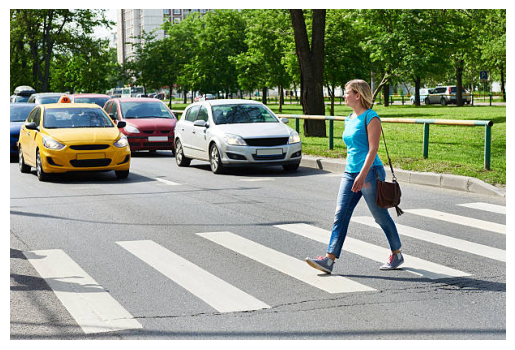

In [15]:
# qwen
image = image_person_cars
prompt = "What is the woman wearing?"

messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}]}]

text = qwen_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = qwen_processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to(device)

with torch.no_grad():
    generated_ids = qwen_model.generate(**inputs, max_new_tokens=256)
    
answer = qwen_processor.batch_decode([out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)], skip_special_tokens=True)[0]
print(f"Answer: {answer}")

img_array = np.array(image)
json_match = re.search(r'```json\n(.*?)\n```', answer, re.DOTALL)
if json_match:
    data = json.loads(json_match.group(1))
    
    if data:
        for item in data:
            if 'bbox_2d' in item:
                x1, y1, x2, y2 = item['bbox_2d']
                label = item.get('label', 'object')
                
                cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 0, 255), 3)
                cv2.putText(img_array, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
plt.imshow(img_array)
plt.axis("off")
plt.show()

Answer: ```json
[
	{"bbox_2d": [116, 113, 209, 185], "label": "cars"},
	{"bbox_2d": [204, 114, 364, 210], "label": "cars"}
]
```


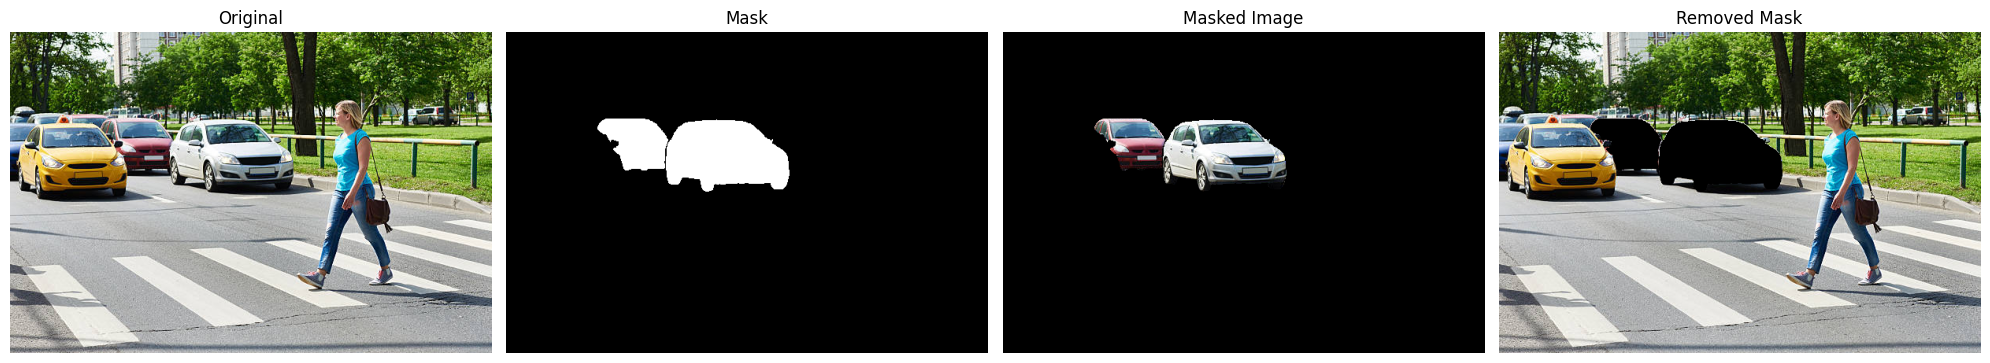

In [ ]:
# qwen + sam

image = image_person_cars
prompt = "Detect cars but not the yellow ones and provide bounding box coordinates."

w, h = image.size
boxes = []
labels = []
messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}]}]

text = qwen_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = qwen_processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to(device)

with torch.no_grad():
    generated_ids = qwen_model.generate(**inputs, max_new_tokens=256)
    
answer = qwen_processor.batch_decode([out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)], skip_special_tokens=True)[0]
print(f"Answer: {answer}")

json_match = re.search(r'```json\n(.*?)\n```', answer, re.DOTALL)
if json_match:
    data = json.loads(json_match.group(1))
    if data:
        img_array = np.array(image)
        boxes = []
        labels = []
        for item in data:
            if 'bbox_2d' in item:
                x1, y1, x2, y2 = item['bbox_2d']
                label = item.get('label', 'object')
                boxes.append([x1, y1, x2, y2])
                labels.append(label)

final_mask = np.zeros((h, w), dtype=np.float32)

if len(boxes) > 0:
        sam_inputs = sam_processor(images=image, input_boxes=[boxes], return_tensors="pt").to(device)

        with torch.no_grad():
            sam_outputs = sam_model(**sam_inputs)

        masks = sam_processor.post_process_masks(sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"])
        iou_scores = sam_outputs.iou_scores.cpu().numpy()
        final_mask = np.zeros((h, w), dtype=np.float32)

        for i in range(len(boxes)):
            detection_masks = masks[0][i].cpu().numpy()
            best_idx = iou_scores[0][i].argmax()
            final_mask += detection_masks[best_idx]

final_mask = np.clip(final_mask, 0, 1)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(final_mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")
masked_img = np.array(image) * final_mask[:,:,None]
axes[2].imshow(masked_img.astype(np.uint8))
axes[2].set_title("Masked Image")
axes[2].axis("off")
inverted_mask = 1 - final_mask
removed_img = np.array(image) * inverted_mask[:,:,None]
axes[3].imshow(removed_img.astype(np.uint8))
axes[3].set_title("Removed Mask")
axes[3].axis("off")
plt.tight_layout()
plt.show()
